In [1]:
import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm



In [26]:
data_name = "HI-II-14"
experiment_type = "ND"
step_ratio = 0.01
read_file_inverse=False

In [27]:
def make_dir(path):
    try: os.makedirs(path)
    except: return -1

In [28]:
CNDP_export_path = os.path.join(".", "Baseline_results")
HDA_export_path = os.path.join(CNDP_export_path, "{}_HDA".format(experiment_type))
HPRA_export_path = os.path.join(CNDP_export_path, "{}_HPRA".format(experiment_type))
CI_export_path = os.path.join(CNDP_export_path, "{}_CI".format(experiment_type))
FINDER_torch_export_path = os.path.join(CNDP_export_path, "{}_FINDER_torch".format(experiment_type))
FINDER_tf_export_path = os.path.join(CNDP_export_path, "{}_FINDER_tf".format(experiment_type))

#CI_export_path = os.path.join(CNDP_export_path, "CI")

#make_dir(CNDP_export_path)
make_dir(HDA_export_path)
make_dir(HPRA_export_path)
make_dir(CI_export_path)
make_dir(FINDER_torch_export_path)
make_dir(FINDER_tf_export_path)

-1

In [29]:
# turns node labels into integers from 1 to |V|
# turn this into graph-tool?
def modify_edgelist(data_dir, save_dir, data_name=['day20']):
    for i in range(len(data_name)):
        data = os.path.join(data_dir , data_name[i] + '.edgelist')
        g = nx.read_edgelist(data)

        nodes = g.nodes()
        nodes_l = list(nodes)
        nodes_l_map = map(int, nodes_l)
        nodes_l_int = list(nodes_l_map)
        nodes_l_int.sort()

        nodes_l_map = map(str, nodes_l_int)
        nodes_l = list(nodes_l_map)

        new_node_labels = {}
        for j in range(len(nodes_l)):
            new_node_labels[nodes_l[j]] = str(j)

        new_g = nx.relabel_nodes(g, new_node_labels)

        nx.write_edgelist(new_g, os.path.join(save_dir, "{}_modified.edgelist".format(data_name[i])))

In [30]:
#modify_edgelist(data_dir, save_dir, data_name=['day20'])

In [31]:
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
G = nx.read_gml(network_file_path, destringizer=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

G_size = G.number_of_nodes()
#total possible pairwise connectivity
CN_denom = (((G_size * (G_size - 1))) /2)
k = int(G_size * step_ratio)
print("Node removals per iteration: ", k)
print("Total possible pairwise connectivity", int(CN_denom))



Number of nodes in the graph: 4165
Number of edges in the graph: 13087
Node removals per iteration:  41
Total possible pairwise connectivity 8671530


In [32]:
network_comma_export_path = "./data/real/{}_comma.txt".format(network_file_name)
nx.write_edgelist(G, network_comma_export_path, delimiter=",")

In [33]:
def calc_graph_connectivity(G, experiment_type=experiment_type):
    _g_num_nodes = G.number_of_nodes()
    if(_g_num_nodes in [0, 1]): return 0
    pairwise_connectivity = 0
    if(experiment_type=="CN"):
        for i in list(nx.connected_components(G)): pairwise_connectivity += (len(i) * (len(i) -1)) / 2
        pc = pairwise_connectivity / CN_denom
        return pc
    else:
        maxCC = len(max(nx.connected_components(G), key=len))
        return maxCC / G_size


In [34]:
# high degree adaptive
def HDA(G, k=k, write=True):
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_graph_connectivity(G))

    print("HDA for k: {}".format(k))

    while(True):
        print("- ", end="")
        degrees = dict(G.degree)
        degrees_sorted = list(sorted(degrees.items(), key=lambda item: item[1], reverse=True))

        isTerminal = k > len(degrees_sorted)

        num_removals = int(min(k, len(degrees_sorted)))
        node_degree_pairs = degrees_sorted[0:num_removals]
        node_removals = [i[0] for i in node_degree_pairs]

        G.remove_nodes_from(node_removals)

        pairwise_conn_list.append(calc_graph_connectivity(G))

        if(isTerminal): break

    print("\t-Finished calculations")

    if(write):
        result_file = os.path.join(HDA_export_path, "{}_scores_k_{}.txt".format(data_name, k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])
        print("\t-Finished export")

    return pairwise_conn_list

In [35]:
# high pageRank adaptive
def HPRA(G, k=k, alpha=0.85, write=True):
    k = int(k)
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_graph_connectivity(G))

    print("HPRA for k: {}, alpha: {}".format(k, alpha))

    while(True):
        print("- ", end="")
        prs = nx.pagerank(G, alpha=alpha)
        prs_sorted = list(sorted(prs.items(), key=lambda item: item[1], reverse=True))

        isTerminal = k > len(prs_sorted)

        num_removals = int(min(k, len(prs_sorted)))
        node_pr_pairs = prs_sorted[0:num_removals]
        node_removals = [i[0] for i in node_pr_pairs]

        G.remove_nodes_from(node_removals)

        pairwise_conn_list.append(calc_graph_connectivity(G))

        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(HPRA_export_path, "{}_scores_k_{}_alpha_{}.txt".format(data_name, k, alpha))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return pairwise_conn_list

In [36]:
def calc_score_from_nodes_file(G, node_files, export_path, k=k, write=True, start_idx=1, read_file_inverse=False):
    pairwise_conn_list = []
    pairwise_conn_list.append(calc_graph_connectivity(G))

    f = open(node_files,'r')
    node_removals = []
    for idx, line in enumerate(f.readlines()):
        nodes_line = line.split(",")[start_idx:]
        node_removals = node_removals + nodes_line

    
    node_removals = [int(node_removals[i]) for i in range(len(node_removals))]
    if(read_file_inverse):
        node_removals = node_removals[::-1]
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]
        #print(curr_node_removals)
        #print("=======")
        G.remove_nodes_from(curr_node_removals)

        pairwise_conn_list.append(calc_graph_connectivity(G))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return pairwise_conn_list

In [37]:
G = nx.read_gml(network_file_path, destringizer=int)
_g_num_nodes = G.number_of_nodes()
print("Successfully imported graph with nodes:", _g_num_nodes)
HDA_scores = HDA(G, k=k)

Successfully imported graph with nodes: 4165
HDA for k: 41
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [38]:
Alphas = [0.8, 0.85, 0.9]


for alpha in Alphas:
    G = nx.read_gml(network_file_path, destringizer=int)
    _g_num_nodes = G.number_of_nodes()
    print("Successfully imported graph with nodes:", _g_num_nodes)
    HPRA_scores = HPRA(G, k=k, alpha=alpha)

Successfully imported graph with nodes: 4165
HPRA for k: 41, alpha: 0.8
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export
Successfully imported graph with nodes: 4165
HPRA for k: 41, alpha: 0.85
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export
Successfully imported graph with nodes: 4165
HPRA for k: 41, alpha: 0.9
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [39]:
# torch
weight_type = "degree"
network_file_name = "{}_{}".format(data_name, weight_type)

torch_FINDER_nodefile_degree_scores = None
network_file_name = "{}_degree".format(data_name)
FINDER_torch_file_path = os.path.join(".", "code", "results", "FINDER_{}_cost".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                            'StepRatio_0.0100', '{}.txt'.format(network_file_name))

G = nx.read_gml(network_file_path, destringizer=int)
_g_num_nodes = G.number_of_nodes()
print(_g_num_nodes)

torch_FINDER_nodefile_degree_scores = calc_score_from_nodes_file(G, FINDER_torch_file_path, FINDER_torch_export_path, k=k, write=True, start_idx=0, read_file_inverse=read_file_inverse)


4165
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [40]:
weight_type = "degree"
network_file_name = "{}_{}".format(data_name, weight_type)
FINDER_tf_file_path = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                            'StepRatio_0.0100', '{}.txt'.format(network_file_name))

G = nx.read_gml(network_file_path, destringizer=int)
_g_num_nodes = G.number_of_nodes()
print(_g_num_nodes)

FINDER_nodefile_degree_scores = calc_score_from_nodes_file(G, FINDER_tf_file_path, FINDER_tf_export_path, k=k, write=True, start_idx=0, read_file_inverse=read_file_inverse)


4165
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [41]:
# for FINDER ND Cost Sparse Torch
weight_type = "random"
network_file_name = "{}_{}".format(data_name, weight_type)

# you need to run CI first
FINDER_tf_file_path = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                            'StepRatio_0.0100', '{}.txt'.format(network_file_name))

G = nx.read_gml(network_file_path, destringizer=int)
_g_num_nodes = G.number_of_nodes()
print(_g_num_nodes)

FINDER_nodefile_random_scores = calc_score_from_nodes_file(G, FINDER_tf_file_path, FINDER_tf_export_path, k=k, write=True, start_idx=0, read_file_inverse=read_file_inverse)


4165
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
	-Finished export


In [42]:
weight_type = "degree"
network_file_name = "{}_{}".format(data_name, weight_type)

FINDER_tf_fscores_file = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                            'StepRatio_0.0100', 'MaxCCList__Strategy_{}.txt'.format(data_name))

FINDER_f = open(FINDER_tf_fscores_file, "r")
tf_degree_scores = []
for score in FINDER_f:
    tf_degree_scores.append(float(score))
tf_degree_final_scores = tf_degree_scores[::k]
#print(tf_degree_final_scores)

In [43]:
weight_type = "random"
network_file_name = "{}_{}".format(data_name, weight_type)

FINDER_tf_fscores_file = os.path.join(".", "code", "results", "old_FINDER_{}_cost_tf".format(experiment_type), 'real', 'Data_{}'.format(weight_type),\
                            'StepRatio_0.0100', 'MaxCCList_Strategy_{}.txt'.format(data_name))

FINDER_f = open(FINDER_tf_fscores_file, "r")
tf_degree_scores = []
for score in FINDER_f:
    tf_degree_scores.append(float(score))
tf_random_final_scores = tf_degree_scores[::k]
#print(tf_random_final_scores)

In [44]:
k

41

In [45]:
exp_dict = {}


In [46]:
Alphas = [0.8, 0.85, 0.9]

for s_r in [step_ratio]:
    k = int(s_r*_g_num_nodes)
    for alpha in Alphas:
        dst_path = os.path.join(HPRA_export_path, "{}_scores_k_{}_alpha_{}.txt".format(data_name, k, alpha))
        f = open(dst_path,'r')
        scores = []
        for idx, value in enumerate(f.readlines()):
            value = float(value)
            scores.append(value)

        #scores = scores[::int(5000/k)]

        exp_dict["HPRA α: {}, k: {}".format(alpha, k)] = scores

In [47]:
for s_r in [step_ratio]:
    k = int(s_r*_g_num_nodes)
    dst_path = os.path.join(HDA_export_path, "{}_scores_k_{}.txt".format(data_name, k))
    f = open(dst_path,'r')
    scores = []
    for idx, value in enumerate(f.readlines()):
        value = float(value)
        scores.append(value)

    #scores = scores[::int(5000/k)]

    exp_dict["HDA k: {}".format(k)] = scores

Text(0, 0.5, 'Graph connectivity ND')

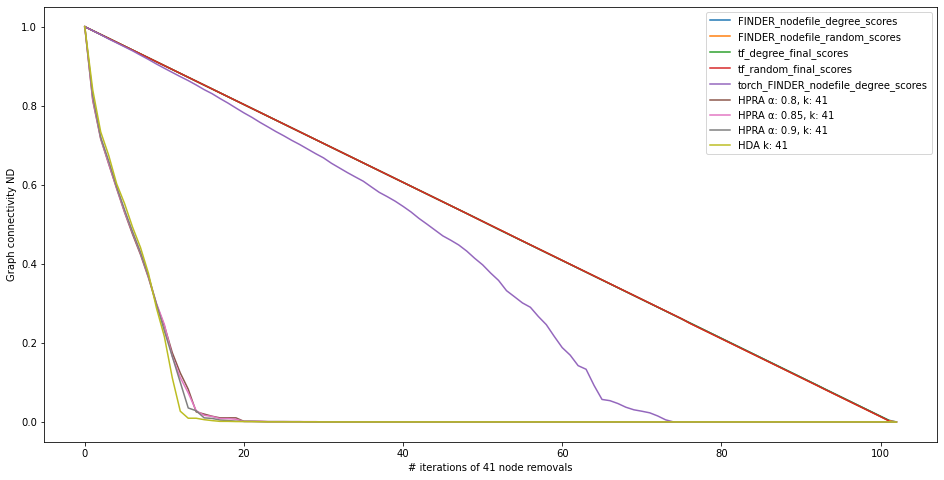

In [48]:
# Reading FINDER files inverse

from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(FINDER_nodefile_degree_scores, label='FINDER_nodefile_degree_scores')
plt.plot(FINDER_nodefile_random_scores, label='FINDER_nodefile_random_scores')

plt.plot(tf_degree_final_scores, label='tf_degree_final_scores')
plt.plot(tf_random_final_scores, label='tf_random_final_scores')
if(torch_FINDER_nodefile_degree_scores):
    plt.plot(torch_FINDER_nodefile_degree_scores, label='torch_FINDER_nodefile_degree_scores')

    

tf_degree_final_scores
#plt.plot(CN_scores, label='CN')
for key in exp_dict.keys():
    plt.plot(exp_dict[key], label=key)
    
#plt.plot(CI_scores, label='CI')
plt.legend()
plt.xlabel("# iterations of {} node removals".format(k))
plt.ylabel("Graph connectivity {}".format(experiment_type))

In [36]:
len(FINDER_torch_scores)

75

In [92]:
G1 = nx.barabasi_albert_graph(n=6, m=4)

G2 = nx.barabasi_albert_graph(n=5, m=4)

G3 = nx.barabasi_albert_graph(n=7, m=4)

G = nx.disjoint_union(nx.disjoint_union(G1, G2), G3)

In [98]:
len(max(nx.connected_components(G), key=len))

7

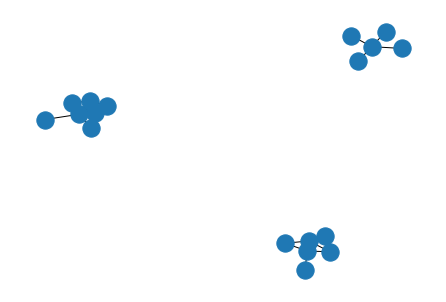

In [94]:
nx.draw(G)


In [90]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6))

In [109]:
[1,2,3][::-1]

[3, 2, 1]